In [3]:
import os
import pickle

import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    TOML_PATH,
    DATA_PATH,
    BUILD_DIR,
)


COLUMNS = ["participant", "compound_position"]


In [4]:
src = os.path.join(BUILD_DIR, "inference.pkl")
with open(src, "rb") as f:
    COMBINED_COMBINATIONS, COMBINED_POSTERIOR_SAMPLES = pickle.load(f)

DATA = pd.read_csv(DATA_PATH)
print(DATA.shape)

config = Config(TOML_PATH)
model = NonHierarchicalBayesianModel(config)


(9126, 46)


In [36]:
def _process(combinations, posterior_samples, positions):
    subjects = sorted(DATA["participant"].unique().tolist())

    a = None
    a_mask = None

    for subject in subjects:
        for position in positions:
            compound_position = position
            curr_combination = (subject, compound_position)

            if curr_combination in combinations:
                ind = [c == curr_combination for c in combinations]
                assert sum(ind) == 1
                if a is None:
                    a = posterior_samples[site.a][:, ind, ...]
                    a_mask = np.full(a.shape, False)
                else:
                    a = np.concatenate([a, posterior_samples[site.a][:, ind, ...]], axis=1)
                    a_mask = np.concatenate(
                        [
                            a_mask,
                            np.full(
                                (
                                    posterior_samples[site.a].shape[0],
                                    1,
                                    posterior_samples[site.a].shape[-1]
                                ),
                                False
                            )
                        ],
                        axis=1
                    )
            else:
                if a is None:
                    a = np.zeros((
                        posterior_samples[site.a].shape[0],
                        1,
                        posterior_samples[site.a].shape[-1]
                    ))
                    a_mask = np.full(a.shape, True)
                else:
                    a = np.concatenate(
                        [
                            a,
                            np.zeros((
                                posterior_samples[site.a].shape[0],
                                1,
                                posterior_samples[site.a].shape[-1]
                            ))
                        ],
                        axis=1
                    )
                    a_mask = np.concatenate(
                        [
                            a_mask,
                            np.full(
                                (
                                    posterior_samples[site.a].shape[0],
                                    1,
                                    posterior_samples[site.a].shape[-1],
                                ),
                                True
                            ),
                        ],
                        axis=1
                    )


    a = a.reshape(
        -1, len(subjects), len(positions), *a.shape[2:]
    )
    a_mask = a_mask.reshape(
        -1, len(subjects), len(positions), *a_mask.shape[2:]
    )

    a = ma.masked_array(a, mask=a_mask)


    def _body_fn_heatmap():
        arr = []
        arr_labels = []

        for l_position_ind, l_position in enumerate(positions):
            if l_position in ['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW']:
                label = f"{l_position.split('-')[0][3:]}-{l_position.split('-')[1][3:]}"
            elif l_position in ['C6LE-C6LC','C6LN-C6LC','C6LNE-C6LC','C6LNW-C6LC','C6LS-C6LC','C6LSE-C6LC','C6LSW-C6LC','C6LW-C6LC']:
                label = f"{l_position.split('-')[0][3:]}-C"
            else:
                label = f"-{l_position.split('-')[1][3:]}"
            arr_labels.append(label)

            for r_position_ind, r_position in enumerate(positions):
                if l_position_ind == r_position_ind:
                    arr.append(1)
                    continue

                l_samples = a[:, :, l_position_ind, ...].mean(axis=0)
                r_samples = a[:, :, r_position_ind, ...].mean(axis=0)
                pvalue = stats.ttest_1samp(l_samples - r_samples, popmean=0, alternative="less", axis=(0, 1)).pvalue
                arr.append(pvalue)

        arr = np.array(arr)
        arr = arr.reshape(-1, len(arr_labels))
        arr_mask = np.diag(arr)
        return arr, arr_labels, arr_mask


    arr, arr_labels, arr_mask = _body_fn_heatmap()
    return arr, arr_labels, arr_mask


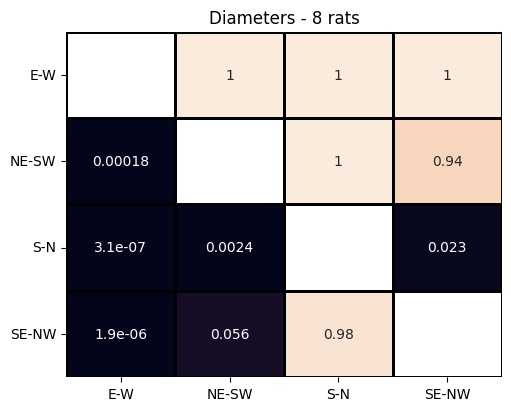

In [22]:
heatmap_kwargs = {
    "linewidths":1, "linecolor":"black", "cbar": False, "vmin": 0, "vmax": 1
}

title = "Diameters - 8 rats"
positions = [
    u[1] for u in COMBINED_COMBINATIONS if (
        # Remove ground contacts
        "" not in u[1].split("-")
        and u[1].split("-")[1][-1] != "C"
    )
]
positions = set(positions)
positions = sorted(list(positions))

arr, arr_labels, arr_mask = _process(
    combinations=COMBINED_COMBINATIONS,
	posterior_samples=COMBINED_POSTERIOR_SAMPLES,
	positions=positions
)

nrows, ncols = 1, 1
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 5, nrows * 4),
    constrained_layout=True,
    squeeze=False
)
ax = axes[0, 0]
sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(arr_mask), **heatmap_kwargs)
ax.tick_params(axis="x", rotation=0)
ax.tick_params(axis="y", rotation=0)
ax.set_title(title);


In [32]:
for pos in positions:
    t = [u[0] for u in COMBINED_COMBINATIONS if u[1] == pos]
    t = set(t)
    print(pos, len(t))


C6LE-C6LC 8
C6LN-C6LC 8
C6LNE-C6LC 8
C6LNW-C6LC 8
C6LS-C6LC 8
C6LSE-C6LC 8
C6LSW-C6LC 8
C6LW-C6LC 8


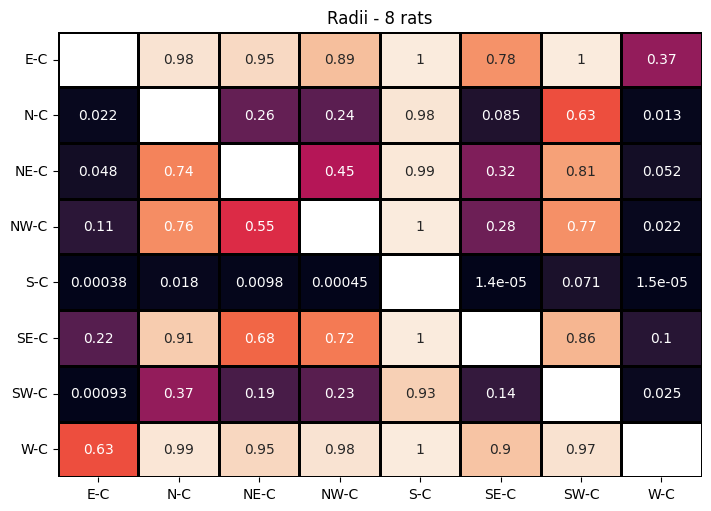

In [34]:
title = "Radii - 8 rats"

positions = [
    u[1] for u in COMBINED_COMBINATIONS if (
        # Remove ground contacts
        "" not in u[1].split("-")
        and u[1].split("-")[1][-1] == "C"
    )
]
positions = set(positions)
positions = sorted(list(positions))

arr, arr_labels, arr_mask = _process(
    combinations=COMBINED_COMBINATIONS,
	posterior_samples=COMBINED_POSTERIOR_SAMPLES,
	positions=positions
)

nrows, ncols = 1, 1
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 7, nrows * 5),
    constrained_layout=True,
    squeeze=False
)
ax = axes[0, 0]
sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(arr_mask), **heatmap_kwargs)
ax.tick_params(axis="x", rotation=0)
ax.tick_params(axis="y", rotation=0)
ax.set_title(title);


In [33]:
for pos in positions:
    t = [u[0] for u in COMBINED_COMBINATIONS if u[1] == pos]
    t = set(t)
    print(pos, len(t))


C6LE-C6LC 8
C6LN-C6LC 8
C6LNE-C6LC 8
C6LNW-C6LC 8
C6LS-C6LC 8
C6LSE-C6LC 8
C6LSW-C6LC 8
C6LW-C6LC 8


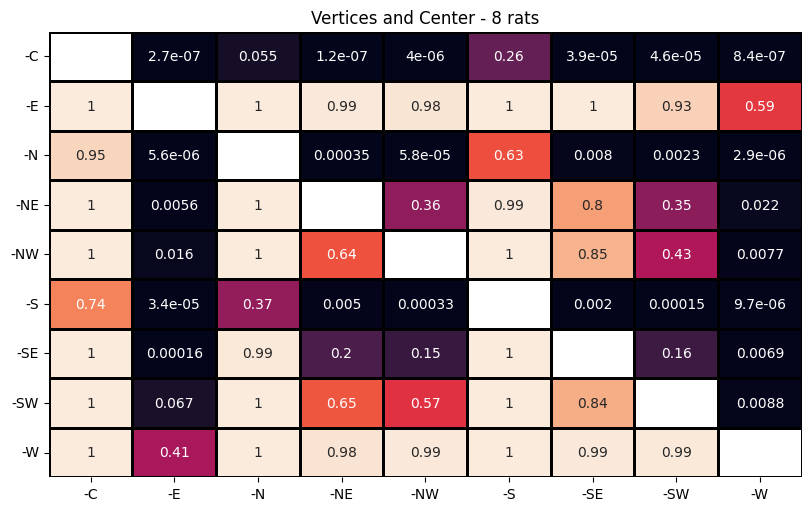

In [43]:
title = "Vertices and Center - 8 rats"

positions = [
    u[1] for u in COMBINED_COMBINATIONS if (
        # Remove ground contacts
        "" in u[1].split("-")
        # and u[1].split("-")[1][-1] != "C"
    )
]
positions = set(positions)
positions = sorted(list(positions))

arr, arr_labels, arr_mask = _process(
    combinations=COMBINED_COMBINATIONS,
	posterior_samples=COMBINED_POSTERIOR_SAMPLES,
	positions=positions
)

nrows, ncols = 1, 1
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 8, nrows * 5),
    constrained_layout=True,
    squeeze=False
)
ax = axes[0, 0]
sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(arr_mask), **heatmap_kwargs)
ax.tick_params(axis="x", rotation=0)
ax.tick_params(axis="y", rotation=0)
ax.set_title(title);


In [44]:
for pos in positions:
    t = [u[0] for u in COMBINED_COMBINATIONS if u[1] == pos]
    t = set(t)
    print(pos, len(t))


-C6LC 8
-C6LE 8
-C6LN 8
-C6LNE 8
-C6LNW 8
-C6LS 8
-C6LSE 8
-C6LSW 8
-C6LW 8


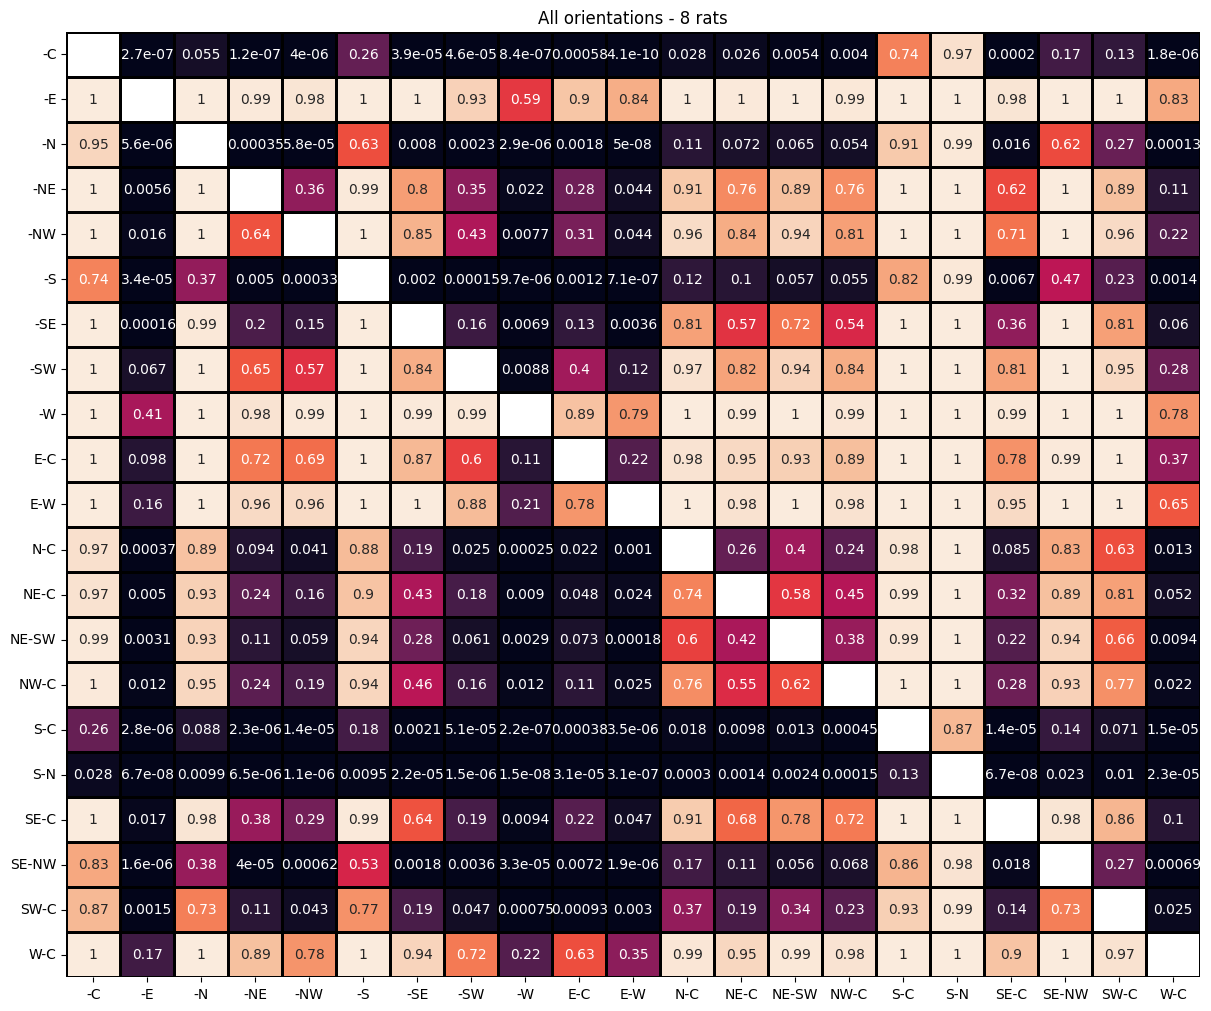

In [47]:
title = "All orientations - 8 rats"

positions = [
    u[1] for u in COMBINED_COMBINATIONS
]
positions = set(positions)
positions = sorted(list(positions))

arr, arr_labels, arr_mask = _process(
    combinations=COMBINED_COMBINATIONS,
	posterior_samples=COMBINED_POSTERIOR_SAMPLES,
	positions=positions
)

nrows, ncols = 1, 1
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 12, nrows * 10),
    constrained_layout=True,
    squeeze=False
)
ax = axes[0, 0]
sns.heatmap(arr, xticklabels=arr_labels, yticklabels=arr_labels, annot=True, ax=ax, mask=np.diag(arr_mask), **heatmap_kwargs)
ax.tick_params(axis="x", rotation=0)
ax.tick_params(axis="y", rotation=0)
ax.set_title(title);
